# AutoBacktest
Given a specific ticker, will return the backtest results of using Facebook Prophet as a trading strategy.

In [53]:
# Libraries
from eod import EodHistoricalData
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import numpy as np
import plotly.express as px
from prophet import Prophet
import yfinance as yf

# Importing and assigning the api key
with open("../../eodHistoricalData-API.txt", "r") as f:
    api_key = f.read()
    
# EOD Historical Data client
client = EodHistoricalData(api_key)

# Get Price Data

In [142]:
def getStockPrices(stock, n_days, training_days, mov_avg):
    """
    Gets stock prices from now to N days ago and training amount will be in addition 
    to the number of days to train.
    """
    
    # Designating the Ticker
    ticker = yf.Ticker(stock)

    # Getting all price history
    prices = ticker.history(period="max")
    
    # Check on length
    if len(prices)<n_days+training_days+mov_avg:
        return None
    
    # Getting relevant length
    prices = prices.tail(n_days+training_days+mov_avg)
        
    # Filling NaNs with the most recent values for any missing data
    prices = prices.fillna(method='ffill')
    
    # Getting the N Day Moving Average and rounding the values for some light data preprocessing
    prices['MA'] = prices[['Close']].rolling(
        window=mov_avg
    ).mean().apply(lambda x: round(x, 2))

    # Resetting format for FBP
    prices = prices.reset_index().rename(
        columns={"Date": "ds", "MA": "y"}
    )
    
    # Dropping the Nans
    prices.dropna(inplace=True, subset=['y'])
    
    return prices

In [211]:
def fbpTrainPredict(df, forecast_period):
    """
    Uses FB Prophet and fits to a appropriately formatted DF. Makes a prediction N days into 
    the future based on given forecast period. Returns predicted values as a DF.
    """
    # Setting up prophet
    m = Prophet(
        daily_seasonality=True, 
        yearly_seasonality=True, 
        weekly_seasonality=True,
        interval_width=.25
    )
    
    # Fitting to the prices
    m.fit(df[['ds', 'y']])
    
    # Future DF
    future = m.make_future_dataframe(
        periods=forecast_period,
        freq='B',
        include_history=False
    )
            
    # Predicting values
    forecast = m.predict(future)

    # Returning a set of predicted values
    return forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [212]:
def runningFBP(prices, forecast_period, training_days):
    """
    Runs Facebook Prophet to get predictions over a set period 
    of time. Uses FBP to train and predict every N days and gets the 
    price forecasts.
    """
    # DF for the predicted values
    pred_df = pd.DataFrame()

    # Running the model each day
    for i in tqdm(range(training_days, len(prices)+1)):
        
        # Training and Predicting the last day on the forecast
        forecast = fbpTrainPredict(
            prices[i-training_days:i], 
            forecast_period
        ).tail(1)
        
        # Adding the forecast predicted
        pred_df = pred_df.append(forecast, ignore_index=True)
        
    # Prepping for merge by converting date values to be the same type
    pred_df['ds'] = pred_df['ds'].apply(lambda x: str(x)[:10])

    prices['ds'] = prices['ds'].apply(lambda x: str(x)[:10])
    
    # Shifting the forecasts back in order to compare it to the 'current' open values
    pred_df[['yhat', 'yhat_lower', 'yhat_upper']] = pred_df[['yhat', 'yhat_lower', 'yhat_upper']].shift(-forecast_period)
    
    # Merging with the prices DF in order to compare values for positions later
    merge_df = prices[['ds', 'Open']].merge(
        pred_df,
        on='ds',
        how='outer'
    ).dropna().set_index('ds')

    return merge_df

In [228]:
# Pricing Data Parameters
n_days = 365

training_days = 200

mov_avg = 5

forecast_period = 5

# Retrieving prices with the above parameters
prices = getStockPrices(
    "SNDL", 
    n_days=n_days,
    training_days=training_days, 
    mov_avg=mov_avg
)

In [229]:
# Running Facebook Prophet with the set parameters
pred_df = runningFBP(
    prices, 
    forecast_period, 
    training_days
)

100%|██████████| 367/367 [03:00<00:00,  2.04it/s]


# Getting Positions

In [230]:
def fbpPositions(pred_df, short=True):
    """
    Gets positions based on the predictions and the actual values.
    """
    if pred_df['Open'] < pred_df['yhat_lower']:
        return 1
    elif pred_df['Open'] > pred_df['yhat_upper'] and short:
        return -1
    else:
        return 0

In [231]:
# Adding sentiment positions to the forecast DF
positions = pred_df

# Getting forecast prophet positions
positions['fbp_positions'] = positions.apply(
    lambda x: fbpPositions(x, short=True), 
    axis=1
)

# Buy and hold position
positions['buy_hold'] = 1

# Backtest

In [232]:
# Getting returns each hour
log_returns = prices[['ds', 'Close']].set_index(
    'ds'
).loc[positions.index].apply(np.log).diff()

In [233]:
# The positions to backtest (shifted ahead by 1 to prevent lookahead bias)
bt_positions = positions[[
    'buy_hold', 
    'fbp_positions'
]].shift(1)

# The returns during the backtest
returns = bt_positions.multiply(
    log_returns['Close'], 
    axis=0
)

# Inversing the log returns to get daily portfolio balance
performance = returns.cumsum().apply(
    np.exp
).dropna().fillna(
    method='ffill'
)

# Calculating Average Returns

In [244]:
loss = performance.diff(10)

loss.min()

buy_hold        -8.393782
fbp_positions   -2.197924
dtype: float64

# Visualization

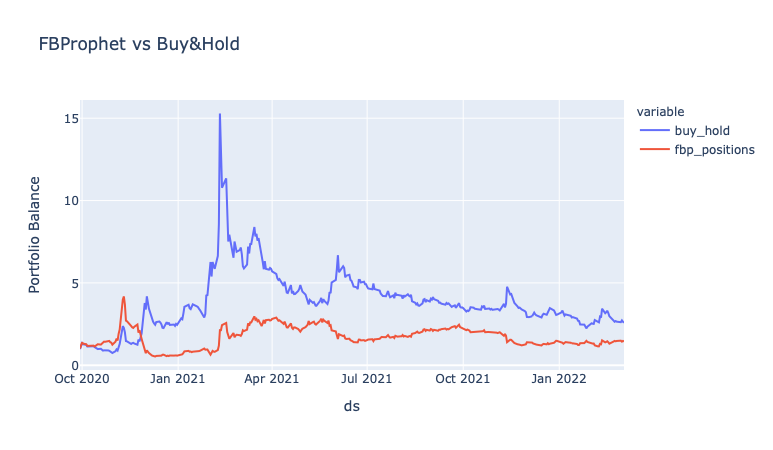

In [235]:
# Visualizing results
fig = px.line(
    performance,
    x=performance.index,
    y=performance.columns,
    title='FBProphet vs Buy&Hold',
    labels={"value": "Portfolio Balance",
            "index": "Date"}
)

fig.show()